<a href="https://colab.research.google.com/github/KumarGaurav20/Spam-Emails/blob/main/Spam_Filteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FILTERING AND VISUALIZING EMAILS** 

In [52]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

# For Natural Language Processing
import nltk
from nltk.stem import PorterStemmer     #For stemming(reduction of words)
from nltk.stem import SnowballStemmer   #Another Stemming Methdd
from nltk.corpus import stopwords       #For filtering stopwords(the, is, etc.)
from nltk.tokenize import word_tokenize #For tokkenizing words
from bs4 import BeautifulSoup           #For removing html

from sklearn.model_selection import train_test_split #for training and splitting data

%matplotlib inline

CONSTANTS


In [54]:
FILE_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/practice_email.txt'
DATA_JSON_FILE= '/content/gdrive/MyDrive/COLAB DATA/email-text-data.json'
WORD_ID_FILE= '/content/gdrive/MyDrive/COLAB DATA/word-by-id.csv'

SPAM_1_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
HAM_11_PATH= 'D:\Machine Learning\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\SpamData\01_Processing\spam_assassin_corpus\easy_ham_1'
HAM_2_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT= 1
HAM_CAT= 0

VOCAB_SIZE=2500


Function for Email Body Generation


In [55]:
# Fuction to generate the email body
def email_body_generator(path):
  for root, dirnames, filenames in walk(path): #walk iterates and returns the three tuple pf files in a  given folder
    for file_name in filenames:
      
      filepath= join(root, file_name)
      stream= open(filepath, encoding='latin_1')
      #checking if it's email body or not
      is_body= False 
      #for reading the lines into a list
      lines=[] 
      for line in stream:
        if is_body:
          lines.append(line)
      #check for new line(as header is separated with body by a new line )
        elif line=="\n":
          is_body=True
          
      stream.close()
      # converting the list into a string
      email_body='\n'.join(lines)
      #yield is a special return type that remembers previous output
      yield file_name, email_body 
      

Function for generating dataframe of email_body


In [56]:
# classification is the category(group no) that we'll provide
def df_from_email_body(path, classification):
  rows=[]
  row_names=[]

  for file_name, email_body in email_body_generator(path):
    rows.append({'Message': email_body, 'Category': classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)


Generating Dataframe of Spam & Normal Emails

In [57]:
spam_emails = df_from_email_body(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_email_body(SPAM_2_PATH, SPAM_CAT))



In [58]:

ham_emails = df_from_email_body(HAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_email_body(HAM_2_PATH, HAM_CAT))

In [59]:
data_combined= pd.concat([spam_emails, ham_emails])

In [60]:
data_combined.head()

,Message,Category
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00292.dbf78a2aaa230d288eb80ab843804252,"REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...",1
00367.9688cdee9dfe720c297672c8f60d998f,++++++++++++++++++++++++++++++++++++++++++++++...,1
00282.0e230e05877f40a522bfb93aa3e314f3,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...,1
00448.a6ac96e93ef03ec1a638c577c6940f5e,<html>\n\n\n\n<head>\n\n<title>Classic Wines</...,1


In [61]:
data_combined.tail()

,Message,Category
01037.bfe999fe03b3c6b5b7cc2360c793e5a0,"On Thu, 2002-08-15 at 17:53, Jesse wrote:\n\n>...",0
01057.b2810601523d3bb9051088959078e309,"Hello Gary,\n\n\n\n\n\nUh, plague is not actio...",0
01261.8335ae817bc240842df41dd7c3de2420,\n\n\n\n> -----Original Message-----\n\n> From...,0
01308.27ef6351cd2bcfef79df9ec5b563afae,"On Tue, Jul 23, 2002 at 03:43:24PM -0400, rODb...",0
00910.4b1bddb9bfc1cea936f0f8cae0cd097d,"On Friday, July 26, 2002, at 12:19 PM, James R...",0


Checking for null columns

In [62]:
data_combined.isnull().sum()

Message     0
Category    0
dtype: int64

Checking for empty data

In [63]:
(data_combined.Message.str.len() == 0).sum()


3

Locating And Removing Empty Strings

In [64]:
# Getting index
data_combined[data_combined.Message.str.len() == 0].index



Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [65]:
# Removing the empty strings
data_combined.drop(['cmds'], inplace=True)

In [95]:
document_ids= range(0, len(data_combined.index))
data_combined['DOC_ID']= document_ids
data_combined['FILENAMES']= data_combined.index
data_combined.set_index('DOC_ID', inplace=True)
data_combined.tail()

,Message,Category,FILENAMES
DOC_ID,,,
5791,"On Thu, 2002-08-15 at 17:53, Jesse wrote:\n\n>...",0,5791
5792,"Hello Gary,\n\n\n\n\n\nUh, plague is not actio...",0,5792
5793,\n\n\n\n> -----Original Message-----\n\n> From...,0,5793
5794,"On Tue, Jul 23, 2002 at 03:43:24PM -0400, rODb...",0,5794
5795,"On Friday, July 26, 2002, at 12:19 PM, James R...",0,5795


Saving Data

In [67]:
data_combined.to_json(DATA_JSON_FILE)

## DATA VISUALIZATION

PIE CHART

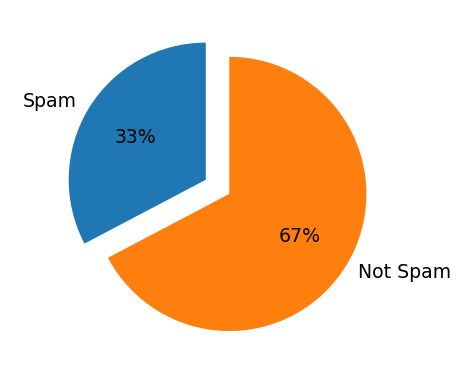

In [68]:
#  Storing amounts
amt_ham, amt_spam= data_combined.Category.value_counts()
category_names = ['Spam', 'Not Spam']
sizes = [amt_spam, amt_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%',  explode = [0.2, 0])
plt.show()

DONUT

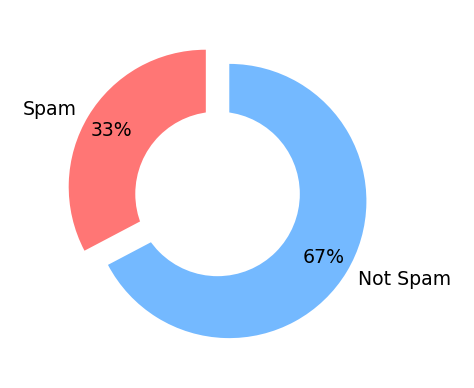

In [69]:

custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=[0.1,0.1])

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## TEXT PREPROCESSING (NLTK )

In [70]:
### Download the NLTK Resources (Tokenizer & Stopwords)
# Punkt is a efficient tokkenizer
nltk.download('punkt')
# Stopwords is a file containing set of all the stopwords. Useflwords= All-Stopwords
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Words Preprocessing

In [71]:
# Function For tokkenizng stemming, removing Html, use beautiful soup(from bs4 import BeautifulSoup)

def clean_msg_no_html(Message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
  soup= BeautifulSoup(Message, 'html.parser')
  cleaned_text= soup.get_text()

  words= word_tokenize(cleaned_text.lower())
  filtered_words=[]
  # removing stopwords
  for word in words:
    if word not in stop_words and word.isalpha():
      filtered_words.append(word)

  return filtered_words
  

In [72]:
# Applying the clean func on all data
# use apply() on all the messages in the dataframe
nested_list_cleaned = data_combined.Message.apply(clean_msg_no_html)


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [73]:
nested_list_cleaned.tail()

DOC_ID
5791    [thu, jesse, wrote, thu, aug, luis, villa, wro...
5792    [hello, gary, uh, plague, action, one, problem...
5793    [message, matthias, saou, mailto, matthias, se...
5794    [tue, jul, rodbegbie, wrote, quite, clear, lis...
5795    [friday, july, pm, james, rogers, wrote, fri, ...
Name: Message, dtype: object

Converting Nested List Into DataFrame


In [74]:
doc_ids_spam = data_combined[data_combined.Category == 1].index
doc_ids_ham = data_combined[data_combined.Category == 0].index

# separating the lists of ham and spam
nested_list_cleaned_ham= nested_list_cleaned.loc[doc_ids_ham]
nested_list_cleaned_spam= nested_list_cleaned.loc[doc_ids_spam]



In [75]:
nested_list_cleaned_ham 

DOC_ID
1896    [tue, aug, voices, made, matt, sergeant, write...
1897    [know, week, catalogue, hokey, changed, back, ...
1898    [hijacker, high, dalal, mughrabi, palestinian,...
1899    [matthias, saou, matthias, also, install, xmms...
1900    [thought, pass, favorite, radio, station, rale...
                              ...                        
5791    [thu, jesse, wrote, thu, aug, luis, villa, wro...
5792    [hello, gary, uh, plague, action, one, problem...
5793    [message, matthias, saou, mailto, matthias, se...
5794    [tue, jul, rodbegbie, wrote, quite, clear, lis...
5795    [friday, july, pm, james, rogers, wrote, fri, ...
Name: Message, Length: 3900, dtype: object

In [76]:
nested_list_cleaned_spam

DOC_ID
0       [fight, risk, cancer, http, slim, guaranteed, ...
1       [register, domains, new, domain, names, finall...
2       [take, control, computer, software, symantec, ...
3       [free, personal, business, grants, qualify, le...
4       [classic, wines, bottles, premium, wine, elega...
                              ...                        
1891    [remove, see, work, company, submits, web, sit...
1892    [html, public, html, link, none, active, none,...
1893    [provide, businesses, types, opportunity, hass...
1894    [dear, homeowner, main, verdana, arial, helvet...
1895    [hi, steph, found, talent, looking, check, fou...
Name: Message, Length: 1896, dtype: object

In [77]:
flat_list_ham = [item for sublist in nested_list_cleaned_ham for item in sublist]
flat_list_ham
nonspammy_words = pd.Series(flat_list_ham).value_counts()


nonspammy_words # total number of unique words in the non-spam messages

http           6607
list           2660
one            2246
would          2003
get            1778
               ... 
parmet            1
briscoe           1
relaunch          1
unchangable       1
ucsd              1
Length: 30011, dtype: int64

In [78]:
flat_list_spam = [item for sublist in nested_list_cleaned_spam for item in sublist]
flat_list_spam
spammy_words = pd.Series(flat_list_spam).value_counts()


spammy_words # total number of unique words in the non-spam messages

http             2906
email            2779
free             2553
click            1945
please           1814
                 ... 
webdunia            1
workshops           1
feefor              1
multinational       1
ccffff              1
Length: 18064, dtype: int64

### Creating a Vocabulary

In [79]:
# This vocab will consist of top, most used words in our dataset
stemmed_nested_list = data_combined.Message.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [80]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 38223


http     9513
list     4212
email    3998
one      3750
get      3477
dtype: int64

In [81]:
#Vocab Size is defined in Constant. VocabSize is equal to top frequent words
frequent_words = unique_words[0:VOCAB_SIZE]
frequent_words


http         9513
list         4212
email        3998
one          3750
get          3477
             ... 
serve          53
spread         53
creative       53
logs           53
developer      53
Length: 2500, dtype: int64

In [82]:
# Converting the list to DataFrame
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,list
2,email
3,one
4,get


In [83]:
# Vocab 
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Generate Features & a Sparse Matrix

In [84]:
type(stemmed_nested_list)

pandas.core.series.Series

In [85]:
# converting series to dataframe (list->individual words)
# stemmed_nested_list = data_combined.Message.apply(clean_msg_no_html)-This contains series of list of words

In [88]:
stemmed_nested_list2 = data_combined.Message.apply(clean_msg_no_html)
word_columns_df= pd.DataFrame.from_records(stemmed_nested_list2.tolist()) #from_records accepts list, tupple, dict etc and makes it a df
word_columns_df.head()

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,fight,risk,cancer,http,slim,guaranteed,lose,lbs,days,http,get,child,support,deserve,free,legal,advice,http,join,web,fastest,growing,singles,community,http,start,private,photo,album,online,http,wonderful,day,offer,manager,prizemama,wish,leave,list,please,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,register,domains,new,domain,names,finally,available,general,public,discount,prices,register,one,exciting,new,domain,names,well,original,names,brand,new,domain,extensions,recently,approved,icann,rights,original,domain,names,biggest,benefit,domain,names,currently,available,much,easier,register,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,take,control,computer,software,symantec,systemworks,software,special,package,includes,six,yes,utilities,special,low,price,software,protect,computer,unwanted,hazardous,viruses,help,secure,private,valuable,information,allow,transfer,files,send,safely,backup,data,quick,easily,improve,pc,performance,integral,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,free,personal,business,grants,qualify,least,free,grants,money,guaranteed,day,one,million,dollars,free,government,grants,given,away,people,like,wide,variety,business,personal,needs,dear,grant,seeker,moment,tell,exactly,get,grants,money,given,away,may,thinking,get,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,classic,wines,bottles,premium,wine,elegant,wine,glasses,capitano,waiter,corkscrew,marble,bottle,stopper,delicious,gourmet,wine,crackers,member,discounts,additional,wine,selections,cellar,profile,newsletter,total,retail,value,special,offer,special,offer,discriminating,wine,drinker,indulge,love,adventure,discovery,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [90]:
word_columns_df.shape

(5796, 7661)

# TESTING AND TRAINING DATA

SPLITTING THE DATA

In [93]:
# from sklearn.model import train_test_split
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data_combined.Category, test_size=0.3, random_state=42)

In [94]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4844,thu,aug,jehan,thought,said,actually,would,inaccurate,action,way,correct,behavior,would,unsubscribe,mailing,list,wow,think,majority,community,would,disagree,makes,difference,list,whether,run,zdnet,empire,towers,whether,uses,open,proxies,relays,mlm,like,mailman,lyris,either,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4727,formail,trick,thanks,answered,sake,archives,patch,ricochet,procmailrc,f,test,formmail,exec,formail,procmail,message,mailto,behalf,sven,willenberger,sent,tuesday,august,pm,zeek,cc,subject,ricochet,question,actually,original,message,zeek,date,tue,aug,subject,ricochet,question,actually,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5022,wintermute,écrit,confused,thought,money,paid,suse,day,support,whatever,oh,year,year,half,ago,suse,revoked,free,offering,retail,distro,sometime,start,great,slump,suse,pulled,free,release,main,product,fine,nobody,oblige,suse,anything,put,ftp,version,surely,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3504,aug,rohit,khare,wrote,datapower,technology,monday,unveiled,network,device,designed,specifically,process,xml,data,unlike,competing,solutions,process,xml,data,software,device,processes,data,hardware,technology,achievement,provides,greater,performance,according,company,officials,sarvega,seems,similar,product,http,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3921,apols,posted,http,rob,yahoo,groups,sponsor,dvds,free,p,join,http,unsubscribe,group,send,email,use,yahoo,groups,subject,http,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [96]:
y_train.head()


DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: Category, dtype: int64

CREATING A SPARSE MATRIX

In [97]:
print(vocab.VOCAB_WORD)

WORD_ID
0            http
1            list
2           email
3             one
4             get
          ...    
2495        serve
2496       spread
2497     creative
2498         logs
2499    developer
Name: VOCAB_WORD, Length: 2500, dtype: object


In [98]:
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,list
2,email
3,one
4,get
...,...
2495,serve
2496,spread
2497,creative


In [99]:
# Getting index of all the vocabulary
word_index = pd.Index(vocab.VOCAB_WORD)


In [101]:
word_index[2]

'email'

CREATING A SPARSE MATRIX FUNCTION

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):  #labels is the categoory
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]                           #Getting the word at the index (i,j)
            if word in word_set:    
                doc_id = df.index[i]                      #Storing the index of word
                word_id = indexed_words.get_loc(word)     #getting index of the word in provided indexed_word(word_index that we've defined above)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)